In [41]:
import os
import sys
import json

curr_path = os.path.dirname(os.path.abspath(__name__))
if curr_path not in sys.path:
    sys.path.insert(0, curr_path)

from configs import IMAGE_SIZE, DEVICE, BEST_MODEL_DIR
from data.fewshotdataloader import generate_loader
from models.protonet import PrototypicalNetwork

from torchmetrics.classification import MulticlassRecall, MulticlassPrecision
import torch

import pandas as pd
import mlflow

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
def evaluate_per_task(
    model,
    support_images, support_labels,
    query_images, query_labels
):
    classification_scores = model(support_images, support_labels, query_images)
    correct = (torch.max(classification_scores.detach().data, 1)[1] == query_labels).sum().item()
    total = query_labels.shape[0]

    return classification_scores, correct, total

In [3]:
def evaluate(model, data_loader, n_way):
    total_pred = 0
    correct_pred = 0
    total_recall = 0
    total_precision = 0

    recall = MulticlassRecall(num_classes=n_way, average='macro')
    precision = MulticlassPrecision(num_classes=n_way, average='macro')

    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, _ in data_loader:
            classification_scores, correct, total = evaluate_per_task(
                model,
                support_images.to(DEVICE), support_labels.to(DEVICE),
                query_images.to(DEVICE), query_labels.to(DEVICE)
            )
            correct_pred += correct
            total_pred += total

            top_scores, pred_labels = torch.max(classification_scores.data, 1)

            total_recall += recall(pred_labels, query_labels).item()
            total_precision += precision(pred_labels, query_labels).item()
    
    avg_accuracy = correct_pred/total_pred
    avg_recall = total_recall/len(data_loader)
    avg_precision = total_precision/len(data_loader)

    return avg_accuracy, avg_recall, avg_precision

In [22]:
def benchmark(model, n_ways, n_shots, metrics):
    results = []
    for n_way in n_ways:
        result = []
        for n_shot in n_shots:
            test_loader = generate_loader(
                'val_test',
                image_size=IMAGE_SIZE,
                n_way=n_way,
                n_shot=n_shot,
                n_query=10,
                n_task=100,
                n_workers=2
            )
            avg_accuracy, avg_recall, avg_precision = evaluate(model, test_loader, n_way)
            result.extend([avg_accuracy, avg_recall, avg_precision])
        results.append(result)
    
    header = [
        [f'{shot}-shot' for shot in n_shots for i in range(len(metrics))],
        [*[metric for metric in metrics]*len(n_shots)]
    ]

    df = pd.DataFrame(
        results,
        index=[f'{way}-way' for way in n_ways],
        columns = header
    )

    return df

In [16]:
# Download artifact model and load model
def get_embedding(run_id, backend):
    artifact_path = os.path.join(BEST_MODEL_DIR, run_id)
    if not os.path.exists(artifact_path):
        mlflow.artifacts.download_artifacts(
            run_id=run_id,
            artifact_path='model',
            dst_path=artifact_path
        )
    embedding = PrototypicalNetwork(
        'convnext_tiny',
        0.5,
        mode='eval'
    ).to(DEVICE)
    embedding = torch.compile(embedding, backend=backend)
    embedding.load_state_dict(torch.load(os.path.join(artifact_path, 'model/model.pt'), map_location=DEVICE))
    embedding = embedding.eval()
    return embedding

In [23]:
n_ways = [3, 6]
n_shots = [3, 10, 20]
metrics = ['accuracy', 'precision', 'recall']

In [24]:
run_id = [
    '9f3784aa59224e52bbf2fef98656a9e6',
    '83d5946a73ec4dae8c7947e6c0c05b7a'
]
backend = ['eager', 'inductor']
model = get_embedding(run_id[1], backend[0])

In [25]:
results = benchmark(model, n_ways, n_shots, metrics)

In [62]:
results.to_csv('../../model/pytorch/best-model/best-model-benchmarks.csv')
results = pd.read_csv('../../model/pytorch/best-model/best-model-benchmarks.csv', header=[0,1], index_col=0)
results

3-shot                       10-shot                       20-shot   
       accuracy precision    recall  accuracy precision    recall  accuracy   
3-way  0.765667  0.765667  0.785895  0.839667  0.839667  0.852500  0.854333  \
6-way  0.634667  0.634667  0.661900  0.729167  0.729167  0.742416  0.751333   

                           
      precision    recall  
3-way  0.854333  0.864061  
6-way  0.751333  0.760780

In [39]:
def plot_benchmark(metric):
    columns = [i if metric=='Accuracy' else i+1 if metric=='Precision' else i+2 for i in [0,3,6]]
    for column in columns:
        plt.plot((n_ways), results.iloc[:,column], '-o', label=results.columns[column][0])
    plt.xticks(n_ways, results.index)
    plt.title(f'Average {metric} by n-way and n-shot', fontsize=15, fontweight='bold')
    plt.ylabel(f'Average {metric}')
    plt.ylim(top=1)
    plt.legend()
    plt.show()

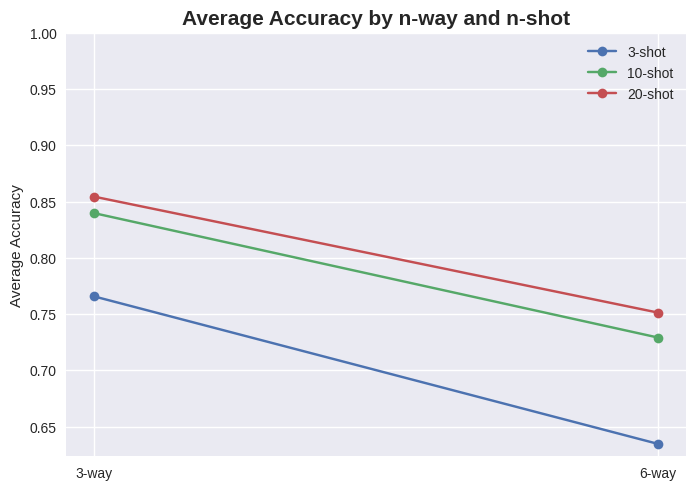

In [40]:
plot_benchmark('Accuracy')

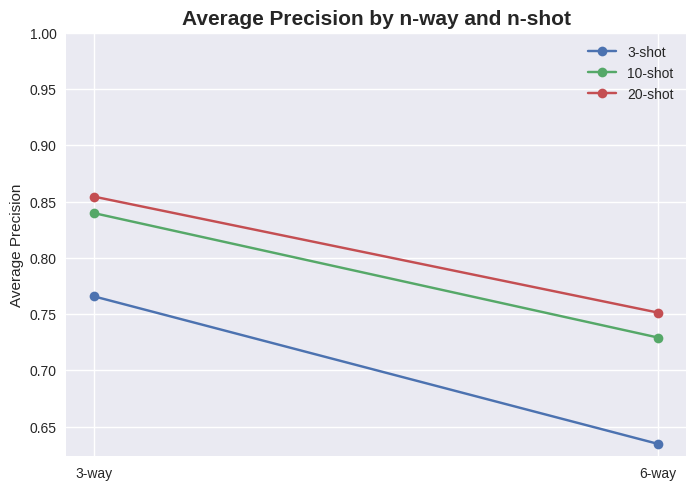

In [42]:
plot_benchmark('Precision')

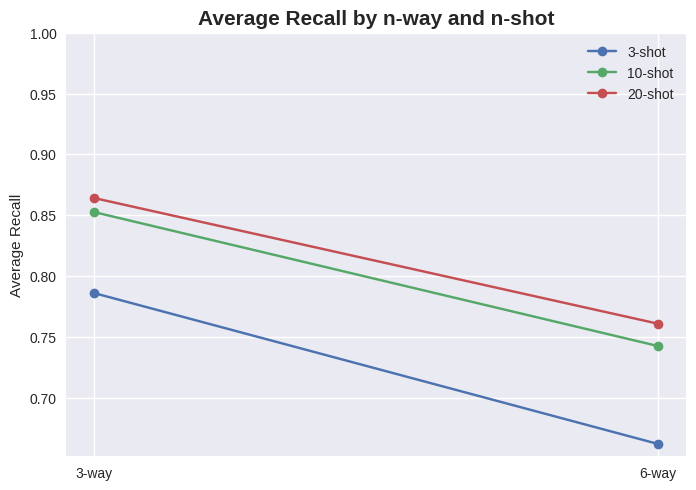

In [43]:
plot_benchmark('Recall')